# Protocolos de Distribuição Quântica de Chaves: BB84 e E91

## BB84

O protocolo BB84, proposto por Charles Bennett e Gilles Brassard em 1984, é o primeiro e mais conhecido protocolo de Distribuição Quântica de Chaves (QKD). Ele utiliza propriedades fundamentais da mecânica quântica para permitir que duas partes (comumente chamadas de Alice e Bob) compartilhem uma chave secreta de forma segura, mesmo na presença de um possível espião (Eve).

No BB84, Alice codifica bits em qubits usando duas bases de medição diferentes (por exemplo, base computacional e base diagonal). Bob mede cada qubit recebido em uma base escolhida aleatoriamente. Após a transmissão, Alice e Bob comparam publicamente as bases utilizadas (mas não os resultados) e mantêm apenas os bits em que as bases coincidiram. A segurança do protocolo decorre do fato de que qualquer tentativa de interceptação e medição dos qubits por Eve introduz distúrbios detectáveis na chave compartilhada.

## E91 (Ekert)

O protocolo E91, proposto por Artur Ekert em 1991, baseia-se no uso de pares emaranhados de qubits (estados de Bell). Nesse protocolo, uma fonte gera pares de qubits emaranhados e envia um qubit para Alice e outro para Bob. Ambos realizam medições em diferentes bases escolhidas aleatoriamente.

A segurança do E91 está fundamentada nas correlações quânticas não-clássicas (emaranhamento) e na violação das desigualdades de Bell. Se um espião tentar interceptar os qubits, as correlações observadas por Alice e Bob não violarão mais as desigualdades de Bell, indicando a presença de uma interceptação.

## Comparação

- **BB84** utiliza qubits individuais e depende da escolha aleatória de bases para garantir a segurança.
- **E91** utiliza pares emaranhados e explora as propriedades do emaranhamento quântico e das desigualdades de Bell.
- Ambos os protocolos permitem a detecção de tentativas de espionagem, mas o E91 oferece uma abordagem baseada em fundamentos ainda mais profundos da mecânica quântica.

Esses protocolos são fundamentais para a segurança da comunicação quântica e representam marcos importantes no desenvolvimento da criptografia quântica.

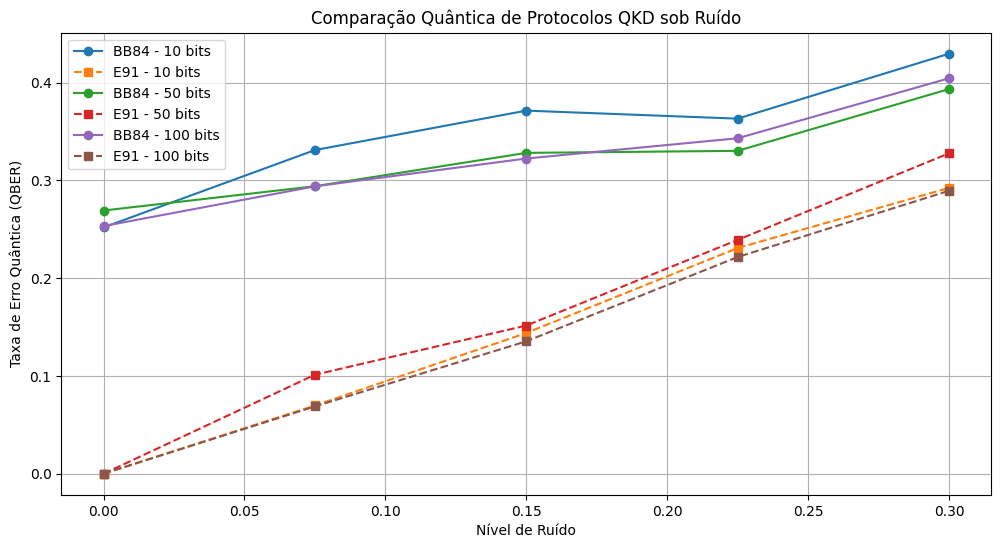

In [11]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Configurações
key_lengths = [10, 50, 100]
noise_levels = np.linspace(0, 0.3, 5)
num_trials = 30

# Dispositivo quântico
dev_bb84 = qml.device("default.qubit", wires=1, shots=1)
dev_ekert = qml.device("default.qubit", wires=2, shots=1)

# BB84: Preparação e medida do qubit
@qml.qnode(dev_bb84)
def bb84_qnode(bit, basis):
    # Preparação do estado inicial |0⟩
    # Se o bit for 1, aplicamos X para obter |1⟩
    if bit == 1:
        qml.PauliX(wires=0)
    
    # Se a base for X (1), aplicamos Hadamard
    if basis == 1:
        qml.Hadamard(wires=0)
    
    # Medição na base Z
    return qml.sample(qml.PauliZ(wires=0))

# E91: Criação de par EPR e medidas correlacionadas
@qml.qnode(dev_ekert)
def ekert_qnode(alice_basis, bob_basis):
    # Criar estado EPR (Bell)
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    
    # Alice mede em sua base
    if alice_basis == 1:
        qml.Hadamard(wires=0)
    
    # Bob mede em sua base
    if bob_basis == 1:
        qml.Hadamard(wires=1)
    
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))

def simulate_bb84_quantum(key_length, noise_level):
    # Contador para o número total de bits após peneiramento
    total_sifted_bits = 0
    # Contador para o número de erros após peneiramento
    total_errors = 0
    
    for _ in range(num_trials):
        # Alice e Bob escolhem bases aleatoriamente
        alice_bases = np.random.randint(2, size=key_length)
        bob_bases = np.random.randint(2, size=key_length)
        
        # Alice escolhe bits aleatórios para enviar
        alice_bits = np.random.randint(2, size=key_length)
        
        # Bob mede os qubits enviados por Alice
        bob_results = []
        for i in range(key_length):
            # Alice prepara o qubit no estado correspondente ao bit e base escolhidos
            result = bb84_qnode(alice_bits[i], alice_bases[i])
            
            # Convertendo o resultado da medição (+1/-1) para bit clássico (0/1)
            # +1 corresponde a 0, -1 corresponde a 1
            bit_result = 0 if result == 1 else 1
            
            # Adiciona ruído (inversão de bit com probabilidade noise_level)
            if np.random.random() < noise_level:
                bit_result = 1 - bit_result
                
            bob_results.append(bit_result)
        
        # Peneiramento: mantém apenas os bits onde Alice e Bob usaram a mesma base
        sifted_indices = [i for i in range(key_length) if alice_bases[i] == bob_bases[i]]
        
        if len(sifted_indices) > 0:
            # Conta o número de bits que não coincidem após o peneiramento
            errors = sum(alice_bits[i] != bob_results[i] for i in sifted_indices)
            
            # Atualiza contadores
            total_errors += errors
            total_sifted_bits += len(sifted_indices)
    
    # Retorna a taxa de erro média (QBER - Quantum Bit Error Rate)
    return total_errors / total_sifted_bits if total_sifted_bits > 0 else 0

def simulate_ekert_quantum(key_length, noise_level):
    total_sifted_bits = 0
    total_errors = 0
    
    for _ in range(num_trials):
        alice_bases = np.random.randint(2, size=key_length)
        bob_bases = np.random.randint(2, size=key_length)
        
        alice_results = []
        bob_results = []
        
        for i in range(key_length):
            a_result, b_result = ekert_qnode(alice_bases[i], bob_bases[i])
            a_bit = 0 if a_result == 1 else 1
            b_bit = 0 if b_result == 1 else 1
            
            # Aplica ruído (opcional, pois o próprio emaranhamento já simula correlações imperfeitas)
            if np.random.random() < noise_level:
                b_bit = 1 - b_bit  # Simula um erro na transmissão
            
            alice_results.append(a_bit)
            bob_results.append(b_bit)
        
        # Peneiração: mantém apenas medições na mesma base
        sifted_indices = [i for i in range(key_length) if alice_bases[i] == bob_bases[i]]
        
        if len(sifted_indices) > 0:
            # No E91, os bits DEVEM ser iguais se medidos na mesma base (em |Φ^+⟩)
            errors = sum(alice_results[i] != bob_results[i] for i in sifted_indices)
            
            total_errors += errors
            total_sifted_bits += len(sifted_indices)
    
    return total_errors / total_sifted_bits if total_sifted_bits > 0 else 0

# Simulação
bb84_results = np.array([[simulate_bb84_quantum(kl, nl) for nl in noise_levels] for kl in key_lengths])
ekert_results = np.array([[simulate_ekert_quantum(kl, nl) for nl in noise_levels] for kl in key_lengths])

# Plot
plt.figure(figsize=(12, 6))
for i, kl in enumerate(key_lengths):
    plt.plot(noise_levels, bb84_results[i], 'o-', label=f'BB84 - {kl} bits')
    plt.plot(noise_levels, ekert_results[i], 's--', label=f'E91 - {kl} bits')

plt.title('Comparação Quântica de Protocolos QKD sob Ruído')
plt.xlabel('Nível de Ruído')
plt.ylabel('Taxa de Erro Quântica (QBER)')
plt.grid(True)
plt.legend()
plt.savefig('quantum_qkd_comparison_corrigido.png', dpi=300)
plt.show()


In [ ]:
import numpy as np

# Simula medições em um estado emaranhado |Φ+⟩
def quantum_correlation(thetaA, thetaB):
    # Probabilidade de resultados iguais (|00⟩ ou |11⟩)
    P_equal = np.cos((thetaA - thetaB)/2)**2
    # Probabilidade de resultados diferentes (|01⟩ ou |10⟩)
    P_diff = np.sin((thetaA - thetaB)/2)**2
    # Correlação E(θA, θB) = P(igual) - P(diferente)
    return P_equal - P_diff #Basicamente se E é aprox 1 os resultados sao altamente correlacionados(mesma base), e se -1 sao anticorrelacionados (bases diferentes)

# Bases de medição (ângulos)
a, a_prime = 0, np.pi/4  # Alice mede em 0° e 45°
b, b_prime = np.pi/8, 3*np.pi/8  # Bob mede em 22.5° e 67.5°

# Calcula S
E_ab = quantum_correlation(a, b)
E_ab_prime = quantum_correlation(a, b_prime)
E_a_prime_b = quantum_correlation(a_prime, b)
E_a_prime_b_prime = quantum_correlation(a_prime, b_prime)

S = abs(E_ab - E_ab_prime + E_a_prime_b + E_a_prime_b_prime)

print(f"S = {S:.4f}")  # Saída: S ≈ 2.3890 

S = 2.3890
